In [42]:
import seaborn as sns

import polars as pl
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings("ignore")

## Описание реализованного класса

Класс Pipeline представляет собой абстрактную основу для построения и запуска пайплайна прогнозирования временных рядов с возможностью логирования, сохранения артефактов и оценки качества моделей. Он реализует общую структуру обработки данных, обучения и инференса, а конкретные реализации моделей задаются через наследование. Поддерживаются как статистические (StatsForecast), так и нейросетевые (NeuralForecast) модели.

### Атрибуты
Основные атрибуты задаются из конфигурации `PipelineConfig`:
- data_path, checkpoint_path, log_dir: пути к данным, контрольным точкам и логам.
- id_column, date_column, target_column, feature_columns: имена колонок входных данных.
- h: горизонт прогноза.
- models: список конфигураций моделей.
- mode: режим работы (`valid` или `inference`).
- metric_names: список метрик для оценки качества.

### Методы
 - read_data(filters=None)
Чтение входных данных из CSV или Parquet. Поддерживается фильтрация при использовании формата Parquet.
 - process_data(data)
Преобразование данных: переименование колонок, преобразование форматов, фильтрация и нормализация целевой переменной.
 - train_test_split(df)
Разделение на обучающую и тестовую выборки по времени с учетом параметров min_date, max_date, h и mode.
 - fit(data)
Обучение моделей, указанных в конфигурации, с использованием соответствующего класса-прогнозировщика. Запрещён повторный запуск.
 - predict(forecaster, test_data)
Прогнозирование с использованием обученного объекта forecaster.
 - calc_metrics(y_true, y_pred)
Вычисление заданных метрик качества (например, mean_absolute_percentage_error) по каждому предсказанию.
 - save_artifacts(predict, forecaster, metrics=None)
Сохранение предсказаний, метрик и модели в директорию эксперимента.
 - run()
Основной метод, запускающий весь пайплайн: чтение, обработка, разделение данных, обучение/загрузка модели, предсказание, вычисление метрик, сохранение результатов.

### Реализации
- `StatsForecastPipeline`: реализация пайплайна с использованием статистических моделей.
- `NeuralForecastPipeline`: реализация пайплайна с использованием нейросетевых моделей.

## Анализ прогнозов statsforecast

Были протестированы модели ARIMA, HoltWinters, MSTL

### Недельный прогноз

In [49]:
pred = pl.read_parquet('../logs/statsforecast_experiment_20250531-133049/prediction.parquet')
metrics = pl.read_csv('../logs/statsforecast_experiment_20250531-133049/metrics.csv')

In [50]:
metrics

model,mean_absolute_error,mean_absolute_percentage_error
str,f64,f64
"""WeekAverage""",5.765986,5.0857e14
"""HoltWinters""",4.782248,4.6094e14
"""ARIMA""",5.017767,7.5890e14
"""MSTL""",6.263022,3.4660e14
"""y""",0.0,0.0


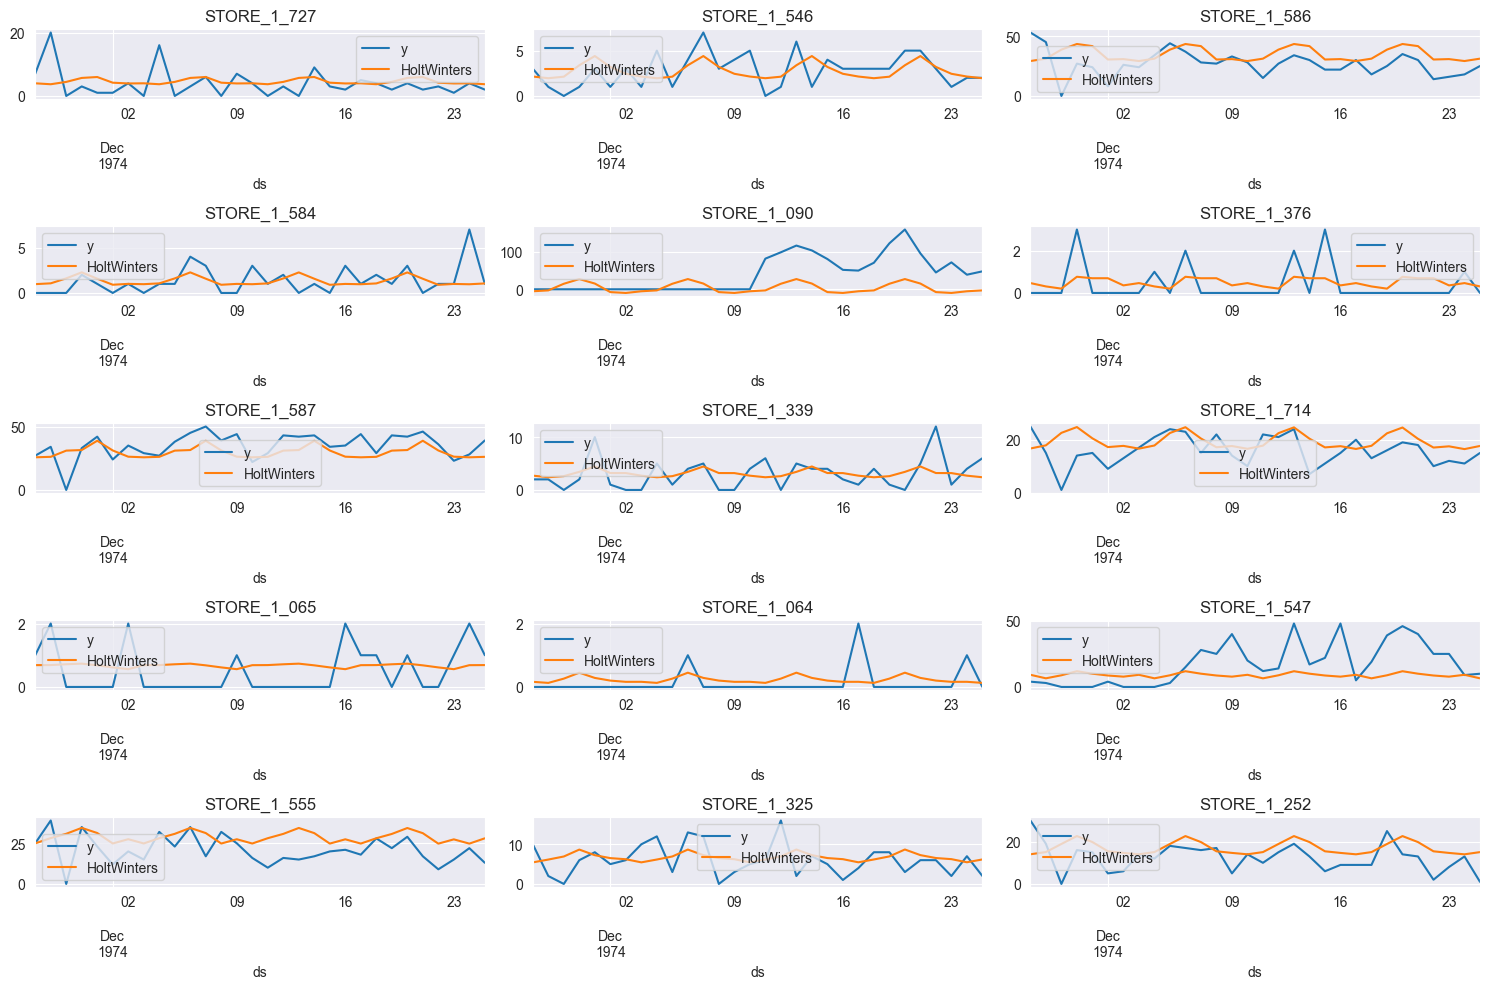

In [48]:
fig, axes = plt.subplots(5, 3,figsize=(15, 10))

for i, art in enumerate(pred['unique_id'].unique()):
    ax = axes[i // 3][i % 3]
    pred.filter(pl.col('unique_id') == art).to_pandas()[['ds', 'y', 'HoltWinters']].plot(x='ds', ax=ax, title=art)

plt.tight_layout()
plt.show()

### Месячный прогноз

In [51]:
pred = pl.read_parquet('../logs/statsforecast_experiment_20250531-133934/prediction.parquet')
metrics = pl.read_csv('../logs/statsforecast_experiment_20250531-133934/metrics.csv')

In [52]:
metrics

model,mean_absolute_error,mean_absolute_percentage_error
str,f64,f64
"""MSTL""",7.468325,4.9422e15
"""ARIMA""",11.748345,5.1473e15
"""HoltWinters""",7.483965,4.5275e15
"""WeekAverage""",7.291746,2.8523e15


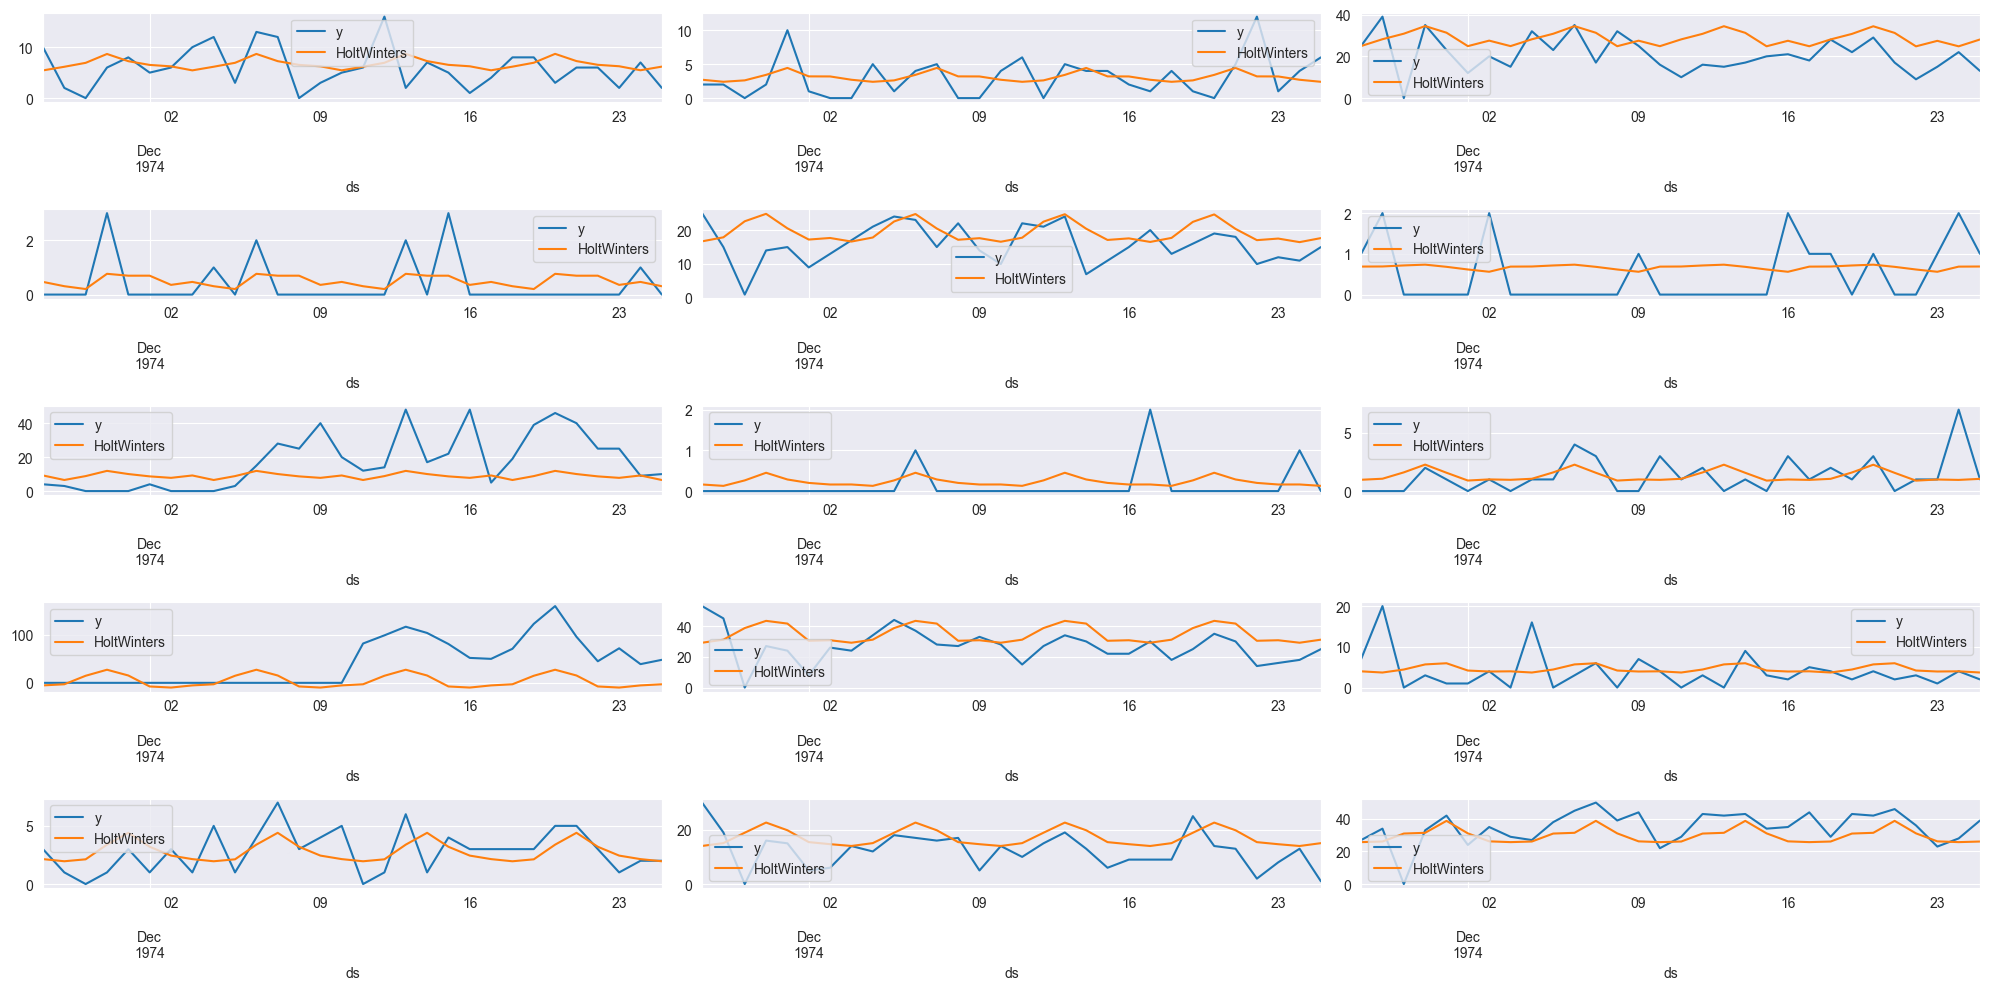

In [25]:
fig, axes = plt.subplots(5, 3,figsize=(20, 10))

for i, art in enumerate(pred['unique_id'].unique()):
    ax = axes[i // 3][i % 3]
    pred.filter(pl.col('unique_id') == art).to_pandas()[['ds', 'y', 'HoltWinters']].plot(x='ds', ax=ax, title=art)

plt.tight_layout()
plt.show()

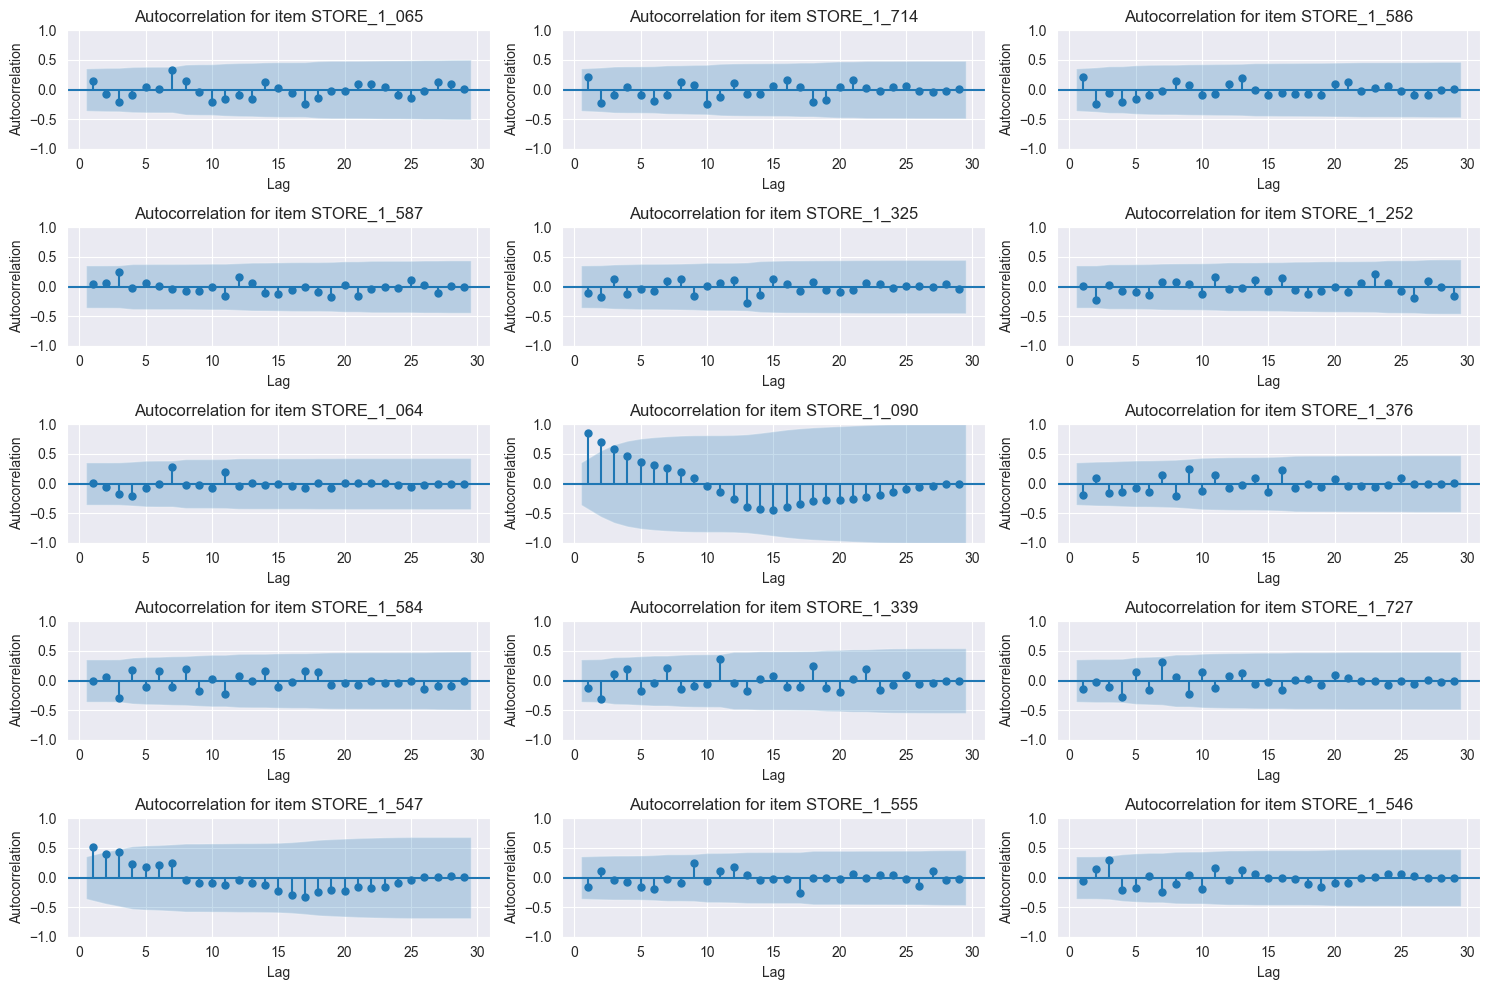

In [29]:
from statsmodels.graphics.tsaplots import plot_acf

pred = pred.with_columns(errors=pl.col('y') - pl.col('HoltWinters'))

fig, axes = plt.subplots(5, 3, figsize=(15, 10))
for i, art in enumerate(pred['unique_id'].unique()):
    ax = axes[i // 3][i % 3]
    group = pred.filter(pl.col('unique_id') == art).sort('ds')
    # Extract count values as numpy array
    ts_values = group['errors'].to_numpy()


    plot_acf(ts_values, ax=ax, lags=29, zero=False)
    ax.set_title(f"Autocorrelation for item {art}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

## Анализ прогнозов neuralforecast

Были протестированы модели NBEATS, KAN

### Недельный прогноз

In [55]:
pred = pl.read_parquet('../logs/neuralforecast_experiment_20250531-135827/prediction.parquet').filter(pl.col('unique_id').str.contains('STORE_1'))
metrics = pl.read_csv('../logs/neuralforecast_experiment_20250531-135827/metrics.csv')

In [56]:
metrics

model,mean_absolute_error,mean_absolute_percentage_error
str,f64,f64
"""NBEATS""",5.345412,3.3646e14
"""KAN""",5.502423,3.5729e14


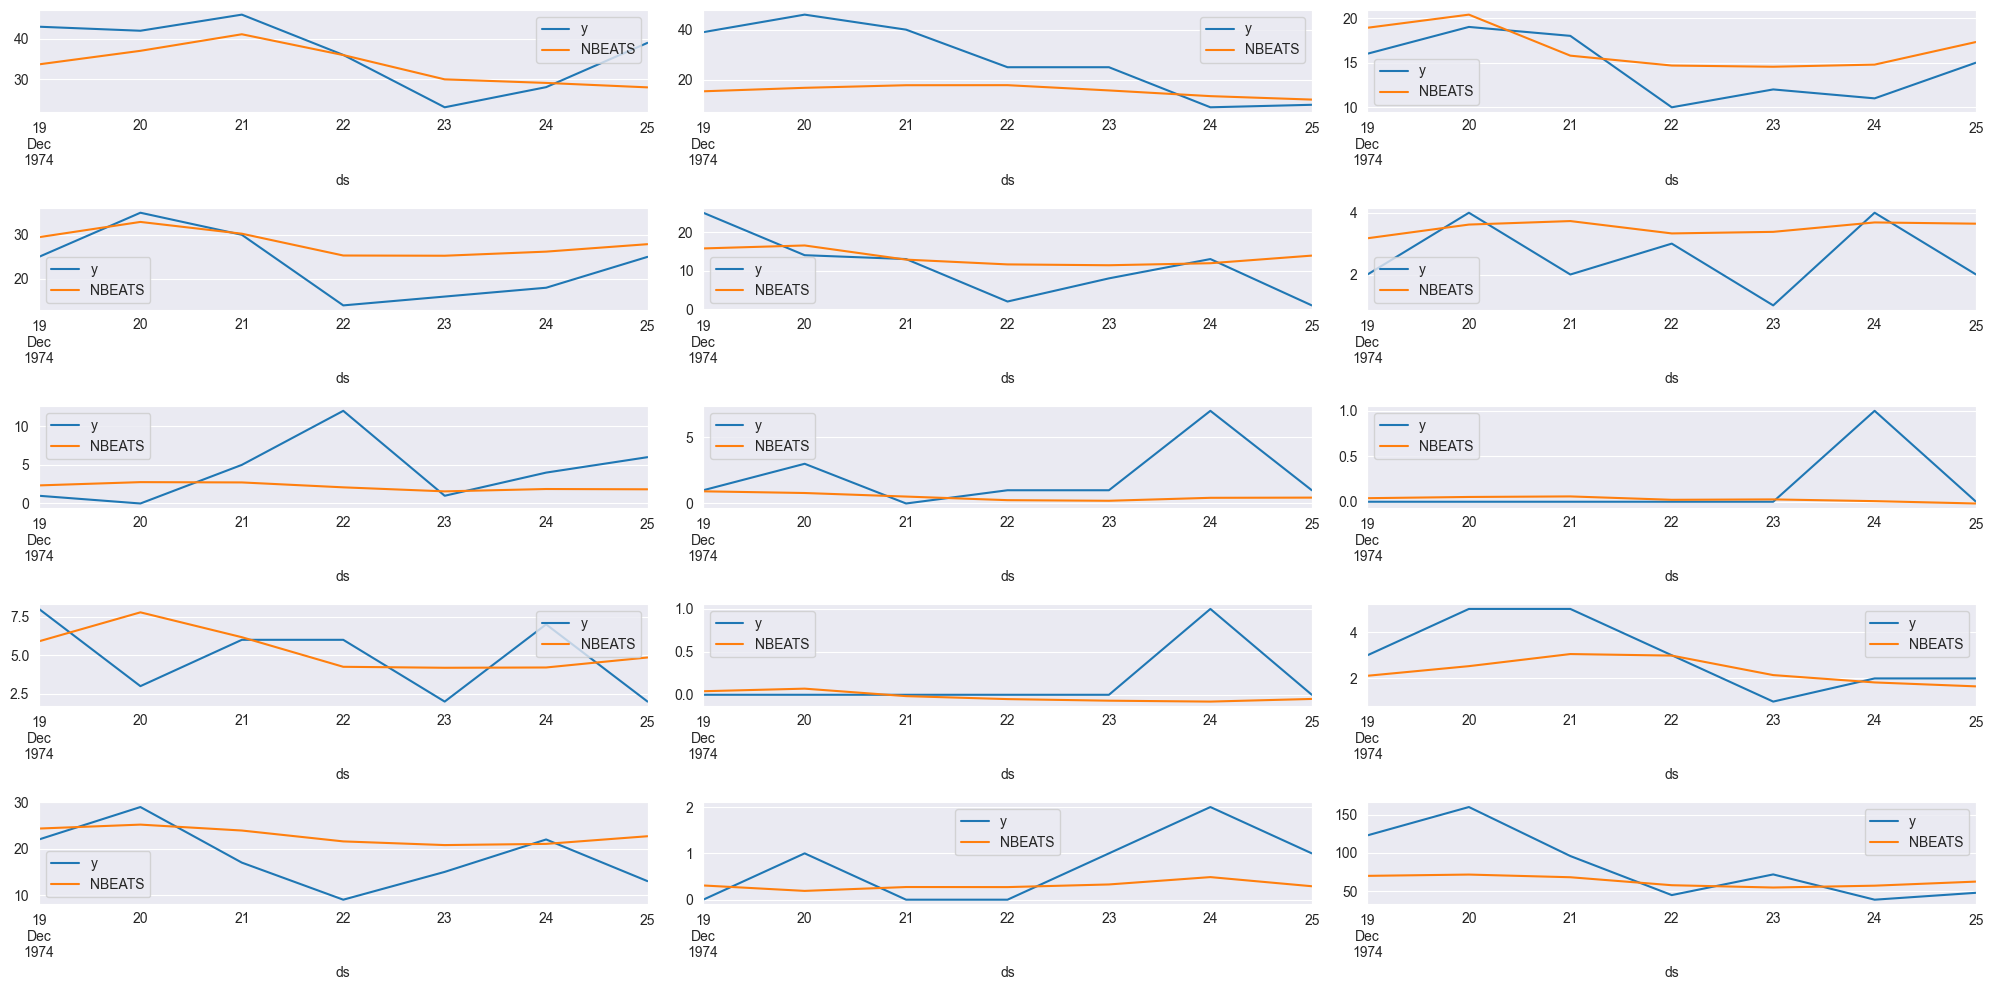

In [37]:
fig, axes = plt.subplots(5, 3, figsize=(20, 10))

for i, art in enumerate(pred['unique_id'].unique()):
    ax = axes[i // 3][i % 3]
    pred.filter(pl.col('unique_id') == art).to_pandas()[['ds', 'y', 'NBEATS']].plot(x='ds', ax=ax, title=art)

plt.tight_layout()
plt.show()

### Месячный прогноз

In [57]:
pred = pl.read_parquet('../logs/neuralforecast_experiment_20250531-135532/prediction.parquet').filter(pl.col('unique_id').str.contains('STORE_1'))
metrics = pl.read_csv('../logs/neuralforecast_experiment_20250531-135532/metrics.csv')

In [58]:
metrics

model,mean_absolute_error,mean_absolute_percentage_error
str,f64,f64
"""NBEATS""",8.265096,5.4115e15
"""KAN""",8.384515,6.5593e15


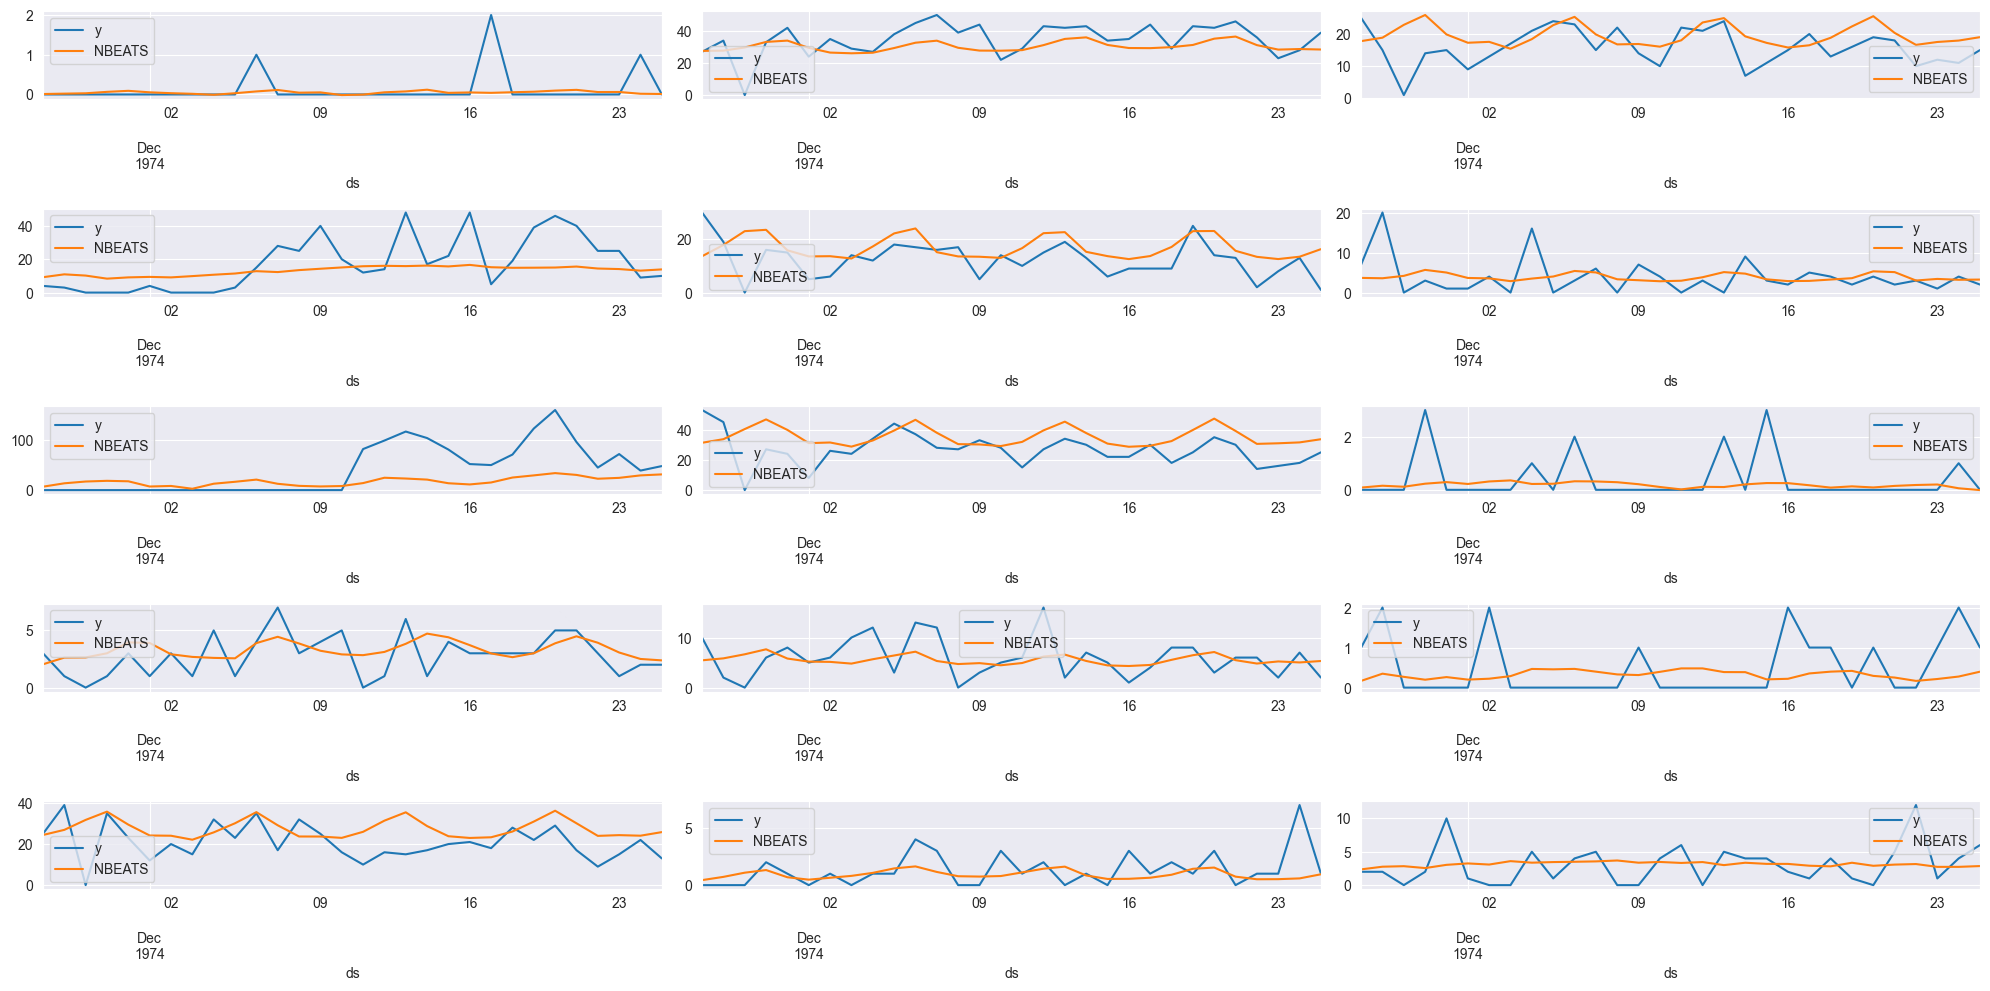

In [39]:
fig, axes = plt.subplots(5, 3, figsize=(20, 10))

for i, art in enumerate(pred['unique_id'].unique()):
    ax = axes[i // 3][i % 3]
    pred.filter(pl.col('unique_id') == art).to_pandas()[['ds', 'y', 'NBEATS']].plot(x='ds', ax=ax, title=art)

plt.tight_layout()
plt.show()

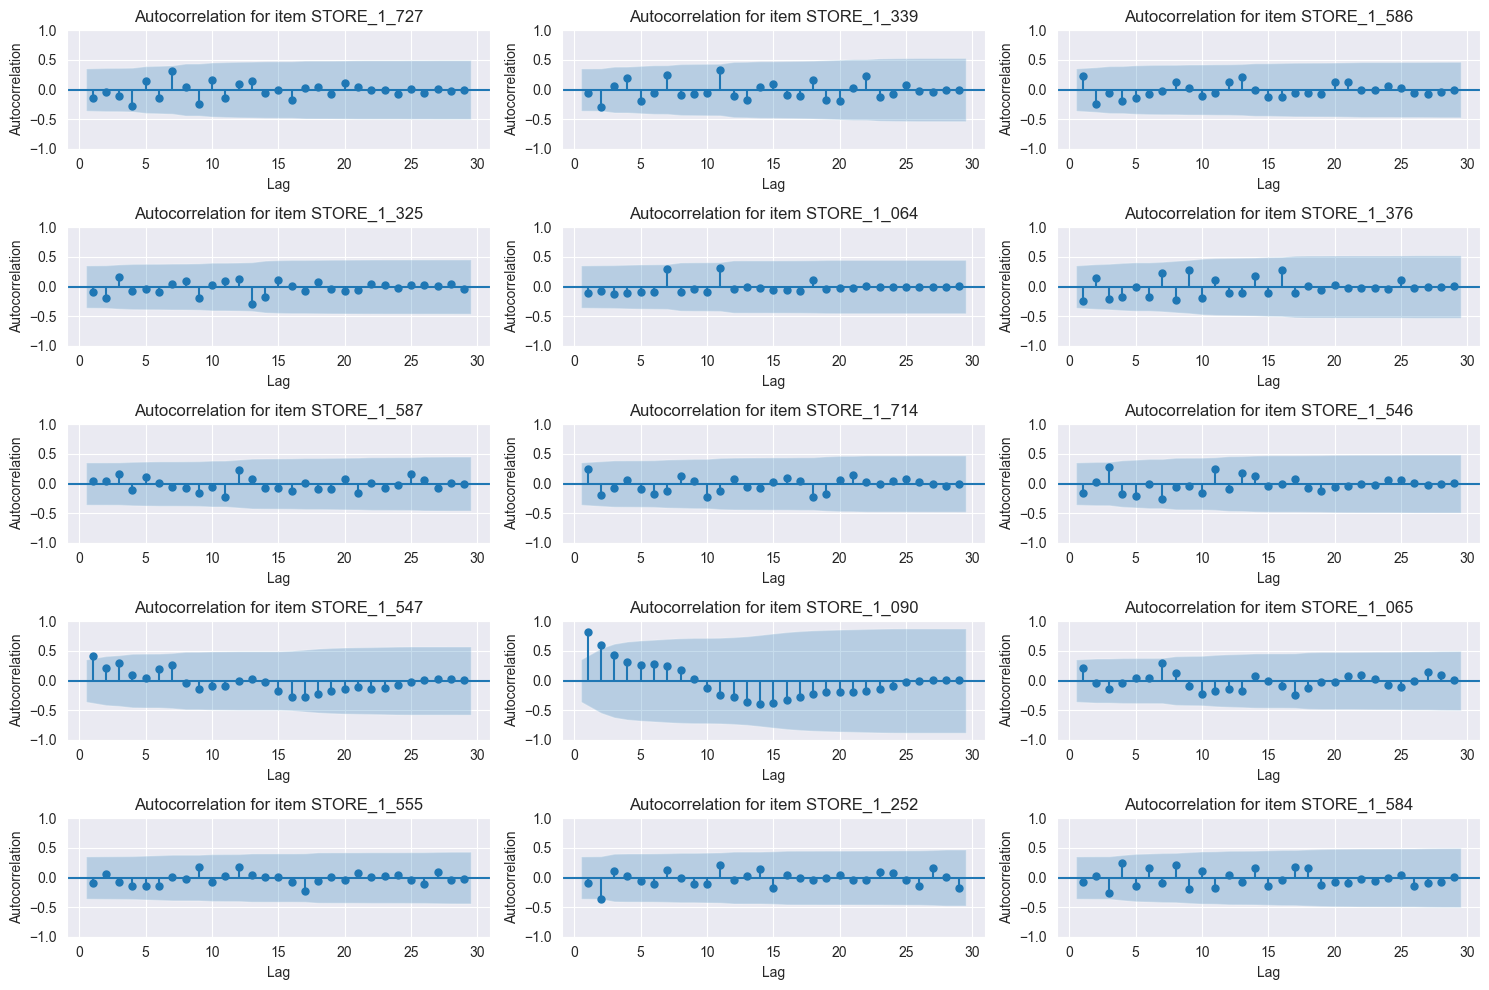

In [41]:
from statsmodels.graphics.tsaplots import plot_acf

pred = pred.with_columns(errors=pl.col('y') - pl.col('NBEATS'))

fig, axes = plt.subplots(5, 3, figsize=(15, 10))
for i, art in enumerate(pred['unique_id'].unique()):
    ax = axes[i // 3][i % 3]
    group = pred.filter(pl.col('unique_id') == art).sort('ds')
    ts_values = group['errors'].to_numpy()


    plot_acf(ts_values, ax=ax, lags=29, zero=False)
    ax.set_title(f"Autocorrelation for item {art}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
plt.tight_layout()
plt.show()